<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Straitforward" data-toc-modified-id="Straitforward-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Straitforward</a></span></li><li><span><a href="#Siamese-classifier" data-toc-modified-id="Siamese-classifier-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Siamese classifier</a></span></li></ul></div>

In [1]:
import keras
from keras.applications import VGG16
from keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split

import os
import cv2
import h5py

import os.path as osp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

/scratch/home/aelphy/py27/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import sys

sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [3]:
DATA_PATH = '../data'

f = h5py.File(osp.join(DATA_PATH, 'nyu_depth_v2_labeled.mat'), 'r')

In [4]:
images = np.swapaxes(f['images'][:], 1, 3)

In [5]:
depths = np.swapaxes(f['depths'][:], 1, 2)

In [6]:
scene_types = []

for ref in f['sceneTypes'][:].ravel():
    scene_types.append(''.join(f[ref][:].view('S2').ravel()))

In [7]:
scene_types = np.array(scene_types)
scene_types

array(['kitchen', 'kitchen', 'office', ..., 'dining_room', 'dining_room',
       'dining_room'], dtype='|S15')

In [8]:
for scene_type in np.unique(scene_types):
    print(scene_type, len(images[scene_types == scene_type]))

('basement', 7)
('bathroom', 121)
('bedroom', 383)
('bookstore', 36)
('cafe', 5)
('classroom', 49)
('computer_lab', 6)
('conference_room', 5)
('dinette', 4)
('dining_room', 117)
('excercise_room', 3)
('foyer', 4)
('furniture_store', 27)
('home_office', 50)
('home_storage', 5)
('indoor_balcony', 2)
('kitchen', 225)
('laundry_room', 3)
('living_room', 221)
('office', 78)
('office_kitchen', 10)
('playroom', 31)
('printer_room', 3)
('reception_room', 17)
('student_lounge', 5)
('study', 25)
('study_room', 7)


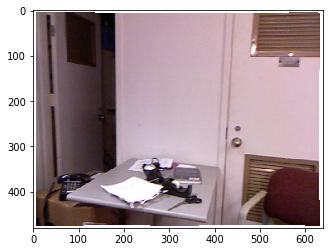

In [9]:
plt.imshow(images[scene_types == 'office'][0])

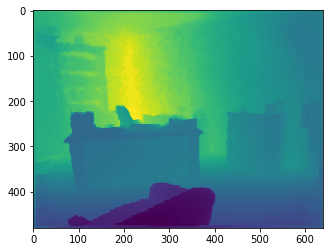

In [10]:
plt.imshow(depths[scene_types == 'home_office'][0])

In [11]:
images_small = np.asarray([cv2.resize(img, (256, 256)) for img in images])
depths_small = np.asarray([cv2.resize(img, (256, 256)) for img in depths]).reshape(-1, 256, 256, 1)

In [13]:
activity1_train, activity1_val = train_test_split(
    np.concatenate([images_small[scene_types == 'office'], depths_small[[scene_types == 'office']]], axis=3),
    test_size = 0.7
)
activity2_train, activity2_val = train_test_split(
    np.concatenate([images_small[scene_types == 'home_office'], depths_small[[scene_types == 'home_office']]], axis=3),
    test_size = 0.7
)

# Straitforward

In [16]:
model = VGG16(include_top=False, weights=None, input_shape=(256, 256, 4))
model.load_weights('../weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5', by_name=True, skip_mismatch=True)
model.trainable = True

In [17]:
predictor = Flatten()(model.output)
predictor = Dense(1024, activation='elu')(predictor)
predictor = Dense(512, activation='elu')(predictor)
predictor = Dense(1, activation='sigmoid')(predictor)

predictor = keras.Model([model.input], [predictor])
predictor.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

In [18]:
X_train = np.vstack([activity1_train, activity2_train])
idxs = np.arange(len(X_train))
targets = np.hstack([np.ones(len(activity1_train)), np.zeros(len(activity2_train))])
BATCH_SIZE = 32
NUM_EPOCHS = 100

for i in range(NUM_EPOCHS):
    predictor.fit(
        X_train[idxs], targets[idxs],
        batch_size=BATCH_SIZE, epochs=1
    )
    
    evaluation = predictor.evaluate(
        np.vstack([activity1_val, activity2_val]),
        np.hstack([np.ones(len(activity1_val)), np.zeros(len(activity2_val))])
    )
    
    print('Loss: {}, Acc: {}'.format(evaluation[0], evaluation[1]))

Epoch 1/1
90/90 [==============================] - 1s 9ms/step
Loss: 1.40063915079, Acc: 0.611111111111
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 0.584185621474, Acc: 0.711111113098
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 0.567665880919, Acc: 0.711111104488
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 0.769369039933, Acc: 0.71111111376
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 0.820392875208, Acc: 0.700000003974
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 0.530224125915, Acc: 0.744444445769
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 0.427268311712, Acc: 0.811111109787
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 0.428934221798, Acc: 0.800000007947
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 0.43872909281, Acc: 0.822222220898
Epoch 1/1
90/90 [==============================] - 0s 4ms/

90/90 [==============================] - 0s 4ms/step
Loss: 0.763661344805, Acc: 0.800000000662
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 0.76427688996, Acc: 0.800000000662
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 0.76427644665, Acc: 0.800000000662
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 0.764334497932, Acc: 0.800000000662
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 0.76447378099, Acc: 0.800000000662
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 0.765050331958, Acc: 0.800000000662
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 0.76628012711, Acc: 0.800000000662
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 0.7676348882, Acc: 0.800000000662
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 0.768984264963, Acc: 0.800000000662
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 0.

# Siamese classifier

In [19]:
BATCH_SIZE = 16

In [20]:
import models.siamese

model = models.siamese.build(
    (256, 256, 4), 1024, 128, 'vgg16'
)

# NOTE: doesn't work with keras
# model.compile(
#     loss=lambda y, x: tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=x)),
#     optimizer=keras.optimizers.RMSprop(1e-5),
#     metrics=[]
# )

labels = tf.placeholder(tf.float32, name='labels')

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=model.output))

global_step = tf.Variable(0, trainable=False)
train_step = tf.train.RMSPropOptimizer(1e-5).minimize(loss, global_step=global_step)
tf.add_to_collection('train_step', train_step)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [21]:
with np.load('../weights/siamese_pretrained_imagenet.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))][0]

In [22]:
def reset_fused_model_to_pretrained_state():
    tf.reset_default_graph()
    global model
    global input1
    global input2
    global sess
    global train_step
    global loss
    global labels
    
    model = models.siamese.build(
        (256, 256, 4), 1024, 128, 'vgg16'
    )

    labels = tf.placeholder(tf.float32, name='labels')

    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=model.output))

    global_step = tf.Variable(0, trainable=False)
    train_step = tf.train.RMSPropOptimizer(1e-5).minimize(loss, global_step=global_step)
    tf.add_to_collection('train_step', train_step)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    input_1 = model.input[0]
    input_2 = model.input[1]
    
    for i, var in enumerate(tf.trainable_variables()[1:]):
        sess.run(var.assign(param_values[i + 1]))

In [23]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def predict(model, inputs):
    return sigmoid(sess.run(model.output, feed_dict={model.input[0] : inputs[0], model.input[1] : inputs[1]}))

def do_test3(test_img, label, g):
    tets_metric1 = 0
    for batch in doors.test_iterate_minibatches(test_img, g.closed_doors, BATCH_SIZE):
        tets_metric1 += predict(model, batch).sum()
    mean1 = tets_metric1 / len(g.closed_doors)
    
    tets_metric2 = 0
    for batch in doors.test_iterate_minibatches(test_img, g.open_doors, BATCH_SIZE):
        tets_metric2 += predict(model, batch).sum()
    mean2 = tets_metric2 / len(g.open_doors)
    
    answer = np.argmin([mean1, mean2])
    
    return answer == label, (mean1, mean2), test_img

def do_test4(test_img, label, g, k):
    tets_metric1 = 0
    idxs = np.random.choice(len(g.closed_doors), size=k)
    for batch in doors.test_iterate_minibatches(test_img, g.closed_doors[idxs], BATCH_SIZE):
        tets_metric1 += predict(model, batch).sum()
    mean1 = tets_metric1 / len(g.closed_doors)
    
    tets_metric2 = 0
    idxs = np.random.choice(len(g.open_doors), size=k)
    for batch in doors.test_iterate_minibatches(test_img, g.open_doors[idxs], BATCH_SIZE):
        tets_metric2 += predict(model, batch).sum()
    mean2 = tets_metric2 / len(g.open_doors)
    
    answer = np.argmin([mean1, mean2])
    
    return answer == label, (mean1, mean2), test_img

In [24]:
import utils.doors_generator as doors

Xc_open = activity1_train
Xc_closed = activity2_train

Xc_open_test = activity1_val
Xc_closed_test = activity2_val

paired_doors_generator_object = doors.MinibatchGenerator(Xc_open, Xc_closed, BATCH_SIZE)
paired_doors_generator = paired_doors_generator_object.run()

reset_fused_model_to_pretrained_state()

In [31]:
cum_loss = 0
num_epochs = 0
    
for i in range(6000):
    b_l, b_r, b_sim = paired_doors_generator.next()

    _, l = sess.run([train_step, loss],
        feed_dict={model.input[0]: b_l, model.input[1]: b_r, labels: b_sim})
    
    cum_loss += l
    num_epochs += 1

    if i % 100 == 0:
        print "\r#%d - Loss"%i, cum_loss / num_epochs
        cum_loss = 0
        num_epochs = 0

#0 - Loss 3.375838423380628e-05
#100 - Loss 1.7172763217558896e-05
#200 - Loss 3.831881138864901e-06
#300 - Loss 1.871589605286772e-06
#400 - Loss 1.4222453364709508e-06
#500 - Loss 9.291122531607243e-07
#600 - Loss 7.618535790498981e-07
#700 - Loss 6.223170646180165e-07
#800 - Loss 5.549652334835286e-07
#900 - Loss 5.16930266130089e-07
#1000 - Loss 4.668300368138034e-07
#1100 - Loss 3.7976723636035105e-07
#1200 - Loss 3.565528149351849e-07
#1300 - Loss 2.8245420262251743e-07
#1400 - Loss 2.807996625975306e-07
#1500 - Loss 2.410519770279507e-07
#1600 - Loss 2.5614694497022585e-07
#1700 - Loss 2.3766679198899966e-07
#1800 - Loss 2.0728681034754005e-07
#1900 - Loss 1.9159738961604944e-07
#2000 - Loss 1.9493262195524608e-07
#2100 - Loss 1.6132418821257487e-07
#2200 - Loss 1.6394366783245573e-07
#2300 - Loss 1.4332852170007015e-07
#2400 - Loss 1.3400593664059103e-07
#2500 - Loss 1.287846573383433e-07
#2600 - Loss 1.3529919741905872e-07
#2700 - Loss 1.1803790131104109e-07
#2800 - Loss 1.222

KeyboardInterrupt: 

In [32]:
def test(k):
    scores = []
    for im in Xc_closed_test:
        scores.append(do_test4(im, 0, paired_doors_generator_object, k))

    for im in Xc_open_test:
        scores.append(do_test4(im, 1, paired_doors_generator_object, k))

    total = 0

    for s in scores:
        total += s[0]

    return total / float(len(scores))

In [33]:
test(1)

0.8333333333333334

In [34]:
test(6)

0.8444444444444444

In [35]:
scores = []
for im in Xc_closed_test:
    scores.append(do_test3(im, 0, paired_doors_generator_object))

for im in Xc_open_test:
    scores.append(do_test3(im, 1, paired_doors_generator_object))

total = 0

for s in scores:
    total += s[0]

total / float(len(scores))

0.8555555555555555